**Sprint 3: Model Development**

In [8]:
#Dependencies
%pip install optuna
%pip install xgboost
%pip install eli5
import os
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier
from optuna import create_study
from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history, plot_param_importances
import optuna
import eli5
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Load the data**

In [9]:
# Load compressed datasets from .npz files
X_test_base = sparse.load_npz("../data/X_test_baseline.npz")
X_train_base = sparse.load_npz("../data/X_train_baseline.npz")
X_test = sparse.load_npz("../data/X_test_engineered.npz")
X_train = sparse.load_npz("../data/X_train_engineered.npz")
y_train = np.load("../data/y_train.npy")

Split the training data into 2 sets: training and validation. We use TimeSeriesSplit for time-aware cross-validation. TimeSeriesSplit returns the first k folds as the train set, while using the k+1-th set as the valid set. This allows the model to be validated against future observations least like those that are used to train the model.

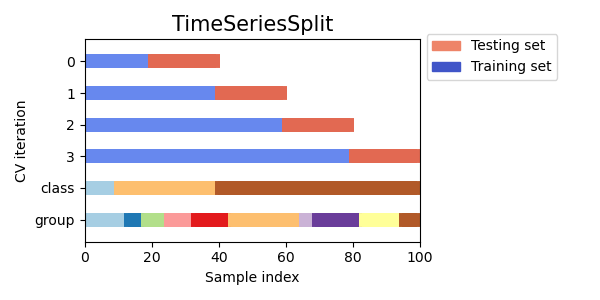

(Note that the index is sorted by time)

In [10]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_train))
train_idx, valid_idx = splits[-1]
X_tr, X_val = X_train_base[train_idx], X_train_base[valid_idx]
y_tr, y_val = y_train[train_idx], y_train[valid_idx]

We propose a list of potential classifiers. I only chose 5, because of hardware constraints.

In [11]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=5000)),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("XGBoost", XGBClassifier())
]

For each classifier:
- Fit on train data
- Generate predictions on validation data
- Graph the predicted values and ground truths on a Receiver Operating Characteristic (ROC) curve

Receiver Operating Characteristic (ROC) curve graphs the true positive rate against false positive rate. Large discrepencies between validation and training ROC curves are evidences for overfitting.
<p align = "center">
<img src="../notebooks/static/roc_curve.png" width="600"/>
<p>

Note that C is not a bad classifier, as the predictions only needs to be reversed to get the same accuracy as C'

Warning: The cell belows takes >15 minutes to run. The entire cell will be commented when one of the classifiers is chosen for further tuning.

In [12]:
# plt.figure(figsize=(10, 8))
# for name, clf in classifiers[:5]:
#    try:
#        clf.fit(X_tr, y_tr)
#        if hasattr(clf, "predict_proba"):
#            y_score = clf.predict_proba(X_val)[:, 1]
#        else:
#            y_score = clf.decision_function(X_val)
#        fpr, tpr, _ = roc_curve(y_val, y_score)
#        roc_auc = auc(fpr, tpr)
#        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
#    except Exception as e:
#        print(f"Skipped {name}: {e}")

# plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")a
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for Classifiers')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.show()

Resulting graph:
<p align = "center">
<img src="../notebooks/static/classifiers_roc_curves.png" width="1000"/>
<p>

The most promising model is LogisticRegression

**Initial Predictions**

We use 2 helper functions from Yury Kashnitsky's notebook - Model validation in a competition.

In [13]:
def write_to_submission_file(predicted_labels, out_file,
                                target='target', index_label="session_id"):
    """
    Save predictions to a CSV file in the required submission format.

    Args:
        predicted_labels (array-like): The predicted values or probabilities for each sample.
        out_file (str): Path to the output CSV file.
        target (str, optional): Name of the target column in the CSV. Default is 'target'.
        index_label (str, optional): Name of the index column in the CSV. Default is 'session_id'.

    Returns:
        None
    """
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
time_split = TimeSeriesSplit(n_splits=10)
site_feature_names = np.load("../data/site_feature_names.npy", allow_pickle=True)
new_feature_names = ["morning", "day", "evening", "summer", "weekday", "year", "session_duration"]

In [15]:
baseline_clf = LogisticRegression(C = 1, max_iter= 5000, random_state = 42)
baseline_clf.fit(X_train_base, y_train)

LogisticRegression(C=1, max_iter=5000, random_state=42)

In [16]:
from IPython.display import display_html, HTML
display_html("<style></style>", raw=True)
display_html(eli5.show_weights(estimator=baseline_clf, feature_names=site_feature_names, top=30))

Weight?,Feature
+6.935,youwatch.org
+5.904,fr.glee.wikia.com
+4.816,vk.com
+4.584,www.info-jeunes.net
+4.531,www.banque-chalus.fr
+4.301,www.audienceinsights.net
+4.133,www.melty.fr
+4.112,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.999,api.bing.com
+3.992,media-1.melty.fr


In [19]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names, 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    """
    Train a model, evaluate with cross-validation, display feature importances, 
    and write test predictions to a submission file.

    Args:
        model: The sklearn-like estimator to train.
        X_train: Training feature matrix.
        y_train: Training target vector.
        X_test: Test feature matrix for prediction.
        site_feature_names: List or array of baseline feature names.
        new_feature_names (list, optional): Additional engineered feature names.
        cv: Cross-validation splitter (default: time_split).
        scoring (str, optional): Scoring metric for cross-validation (default: 'roc_auc').
        top_n_features_to_show (int, optional): Number of top features to display (default: 30).
        submission_file_name (str, optional): Output path for submission CSV.

    Returns:
        np.ndarray: Array of cross-validation scores.
    """
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
    # Ensure new_feature_names is a list (not numpy array or other type)
        all_feature_names = list(site_feature_names) + list(new_feature_names)
    else:
        all_feature_names = list(site_feature_names)
    
    display_html(eli5.show_weights(estimator=model, 
                                   feature_names=all_feature_names, 
                                   top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [28]:
cv_scores1 = train_and_predict(model=baseline_clf, X_train = X_train_base, y_train = y_train, 
                               X_test = X_test_base, site_feature_names = site_feature_names,              
                               cv = time_split, submission_file_name='../data/baseline_logreg_submission.csv')

CV scores [0.83587387 0.65248713 0.85734389 0.93515262 0.84108439 0.88801055
 0.90831387 0.86861264 0.91777072 0.91411213]
CV mean: 0.8618761805430456, CV std: 0.07686339183814671


Weight?,Feature
+6.935,youwatch.org
+5.904,fr.glee.wikia.com
+4.816,vk.com
+4.584,www.info-jeunes.net
+4.531,www.banque-chalus.fr
+4.301,www.audienceinsights.net
+4.133,www.melty.fr
+4.112,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.999,api.bing.com
+3.992,media-1.melty.fr


In [29]:
def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_int('max_iter', 100, 5000)
    C = trial.suggest_float('inverse_regularization_strength', 1, 5)

    clf = LogisticRegression(
        solver='liblinear',
        penalty=penalty,
        max_iter=max_iter,
        random_state=42,
        class_weight='balanced'
    )

    # Use the entire training and validation sets
    clf.fit(X_tr, y_tr)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_val)[:, 1]
    else:
        y_score = clf.decision_function(X_val)
    score = roc_auc_score(y_val, y_score)

    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return score

pruner = MedianPruner(n_startup_trials=2, n_warmup_steps=0)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-23 12:26:14,100] A new study created in memory with name: no-name-27f1c8c7-6205-49fa-a29b-4fffc6395ba9
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
[I 2025-06-23 12:26:18,783] Trial 0 finished with value: 0.9057208647745418 and parameters: {'penalty': 'l1', 'max_iter': 1810, 'inverse_regularization_strength': 3.0571017244923824}. Best is trial 0 with value: 0.9057208647745418.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
[I 2025-06-23 12:26:21,006] Trial 1 finished with value: 0.9136283802243041 and parameters: {'penalty': 'l2', 'max_iter': 3257, 'inverse_regularization_strength': 3.728206547761956}. Best is trial 1 with value: 0.91362838022

Best trial:
  Value: 0.9136283802243041
  Params: 
    penalty: l2
    max_iter: 3257
    inverse_regularization_strength: 3.728206547761956
